#  2. CUDA memory model

In this lecture, we will focus on the memory hierarchy in NVIDIA GPU CUDA-enabled cards. Memory access is often a significant part of GPU kernel execution time, so choosing the right type of memory for the task at hand plays a key role.

During these exercises, we will learn how to use the following types of CUDA memory and what their advantages and limitations are:

1. global memory,
2. shared memory,
3. constant memory,
4. texture memory.

In this and the following notebooks, we will use the tools, tests and benchmarks available in the `gpu_short_course` Python package, which can be found in the repository https://github.com/us4useu/ius-2021-gpu-short-course. Let's do all the necessary imports first:

In [11]:
import math
import cupy as cp
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import gpu_short_course

## 2.1. One-dimensional convolution, global memory

### 2.1.1. The task: 1D convolution on CPU

In this and subsequent notebooks, we will focus on one-dimensional convolution. The convolution operator has very broad applications that also include signal and image processing, and signal filtering in particular.

**Input**: 

- $x$: input signal of length $m$, 
- $h$: impulse response of filter a vector of $n$ samples,

**Output**: $y$: otuput signal of length $m$

The following definition will be used during this course:

\begin{equation*}
y[i] = (x \ast h)[i] = \sum_{j=0}^{n-1} x[i+o-j]h[j] 
\end{equation*}

where:
- $x[k]$ is equal 0 for $k < 0$ (equivalent to convolution with zero-padding),
- $m \ge n$ (for the sake of simplicity), 
- $o$ is the initial offset of the convolution. During the course this will assume the following (which corresponds to the `mode='same'` in the [`numpy.convolve`](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html)):

\begin{equation*}
o = \left\lceil \frac{N}{2} \right\rceil-1
\end{equation*}

Example:

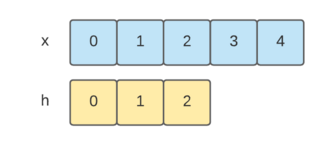

The convolution corresponds to moving the filter $h$ window as follows:

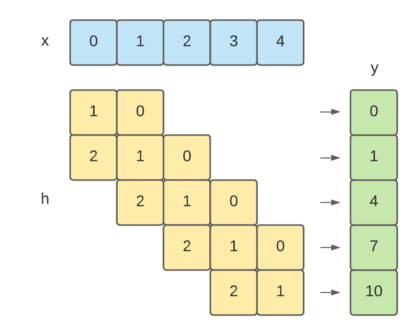

For given input parameters, input offset will be equal to `1`. So, the output signal will be equal to:
```
y[0] = h[0]*x[1]+h[1]*x[0]           = 0
y[1] = h[0]*x[2]+h[1]*x[1]*h[2]*x[0] = 1
y[2] = h[0]*x[3]+h[1]*x[2]*h[2]*x[1] = 4
y[3] = h[0]*x[4]+h[1]*x[3]+h[2]*x[2] = 7
y[4] = h[1]*x[4]+h[2]*x[3]           = 10
```


Let's implement a baseline version of the convolution, first on CPU. We can do it following directly the definition of the convolution.

**Exercise**

Fill in the missing line(s) of code, marked with the `# TODO` comment.

In [2]:
def convolve_cpu(x, h):
    m = len(x)
    n = len(h)
    y = np.zeros(m, dtype=x.dtype)
    o = int(math.ceil(n/2)-1)
        
    # For each output sample.
    for i in range(m):
        value = 0.0
        # For each filter's coefficient.
        for j in range(n):
            # TODO 
        y[i] = value
    return y


result = convolve_cpu(np.array([0, 1, 2, 3, 4]), 
                      np.array([0, 1, 2]))
np.testing.assert_equal(result, [0, 1, 4, 7, 10])
print(result)

[ 0  1  4  7 10]


Now let's check how the `convolve_cpu` function works in filtering less trivial signals. First, we will prepare an artificially noisy signal:

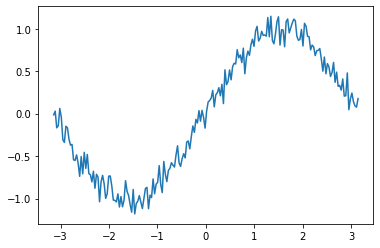

In [3]:
t = np.linspace(-math.pi, math.pi, 200).astype(np.float32)
noisy_signal = np.sin(t) + 0.1*np.random.randn(len(t)).astype(np.float32)
plt.plot(t, noisy_signal)

We will use a [moving average filter](https://en.wikipedia.org/wiki/Moving_average) to remove the (artifically) added noise from the input signal. The moving average filter is simply a vector of $\frac{1}{N}$ values, where $N$ is the size of the filter. 

In [4]:
n = 64
ma_filter = np.ones(n)/n
ma_filter = ma_filter.astype(np.float32)

Finally, let's do the actual filtering:

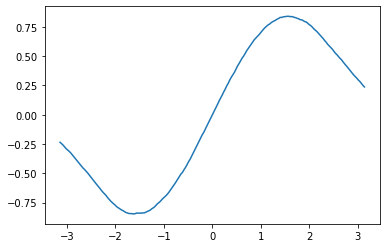

In [5]:
denoised_signal = convolve_cpu(noisy_signal, ma_filter)
plt.plot(t, denoised_signal)

For the purpose of this course we have prepared two functions that check correctness and performance of the implemented functions: 
- `gpu_short_course.tests.test_convolve`: performs validation tests on the passed convolve function,
- `gpu_short_course.tests.benchmark_convolve`: measures the average execution time of the passed function on random data. 

Let's check if the function passes the tests prepared for this course:

In [6]:
gpu_short_course.tests.test_convolve(convolve_cpu)

All tests passed.


If everything is OK, you should see `All tests passed.`

Now, let's see how fast the CPU implementation is:


In [7]:
gpu_short_course.tests.benchmark_convolve(convolve_cpu, x_size=2**15, n=1)

Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 5.0334 seconds (+/- 0.0000), median: 5.0334


In [8]:
gpu_short_course.tests.benchmark_convolve(lambda x, h: np.convolve(x, h, mode='same'), n=10)

Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0386 seconds (+/- 0.0023), median: 0.0384


As we have seen previously, `numpy` function is faster than its Python counterpart.

### 2.1.2. 1D convolution on GPU

Now, let's proceed with implementing 1D convolution on GPU.

We will follow the same approach as we did in Notebook 1: split the 1D convolution task into many smaller subtasks. 

Note that each output value $y[i]$ can be computed independently of the result $y[j]$ (for any $i, j < m$).

So, let's split the convolution into many smaller subtasks, where in each subtask we compute the value of $y[i]$, and assign each subtask to a separate CUDA thread.

**Exercise**

1. Open `2_1_convolve1d.cc` file.
2. Fill in the missing lines of code, marked with the `// TODO` comment.

In [9]:
convolve_gpu_kernel_src = open("2_1_convolve1d.cc").read()
convolve_gpu_kernel = cp.RawKernel(code=convolve_gpu_kernel_src, name="convolve1d")

Let's wrap the above kernel and the thread hierarchy declaration into a complete function, which for a given `x` and `h` returns the result of the convolution:

In [10]:
def convolve_gpu(x, h):
    y = cp.empty(shape=x.shape, dtype=np.float32)
    x = cp.asarray(x.astype(np.float32))
    h = cp.asarray(h.astype(np.float32))
    m = len(x)
    n = len(h)
    o = int(math.ceil(n/2)-1)


    block = 256
    grid = int(math.ceil(m/block))
    block = (block, )
    grid = (grid, )

    convolve_gpu_kernel(grid, block, args=(y, x, h, m, n, o))
    return y.get()

And verify that the above implementation works correctly:

In [11]:
gpu_short_course.tests.test_convolve(convolve_gpu)

All tests passed.


If everything is OK, you should see `All tests passed.` message.


Let's also inspect the result visually:

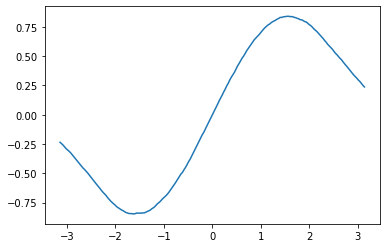

In [12]:
denoised_signal = convolve_gpu(noisy_signal, ma_filter)
plt.plot(t, denoised_signal)

Now it's time to benchmark the GPU implementation:

In [16]:
gpu_short_course.tests.benchmark_convolve(convolve_gpu, n=10)

Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0100 seconds (+/- 0.0081), median: 0.0074


The result will depend on the GPU device you have, but we think you should be able to notice some performance improvement :). 

The average processing time that you see above includes:
- the time required for memory allocations, data transfers from and to GPU device,
- the time required to execute the kernel code. 

Let's use the CUDA profiler to get a bit more detail about the time it takes to complete each step:

In [17]:
%%writefile 2_1_convolve_gpu.py
import math
import numpy as np
import cupy as cp
import gpu_short_course.tests

convolve_gpu_kernel_src = open("2_1_convolve1d.cc").read()
convolve_gpu_kernel = cp.RawKernel(code=convolve_gpu_kernel_src, name="convolve1d")

def convolve_gpu(x, h):
    # Create input parameters, MAKE SURE WE ARE PASSING 32-bit float values.
    y = cp.empty(shape=x.shape, dtype=np.float32) 
    x = cp.asarray(x.astype(np.float32))
    h = cp.asarray(h.astype(np.float32))
    m = len(x)
    n = len(h)
    o = int(math.ceil(n/2)-1)

    block = 256
    grid = int(math.ceil(m/block))
    block = (block, )
    grid = (grid, )

    convolve_gpu_kernel(grid, block, args=(y, x, h, m, n, o))
    return y.get()

gpu_short_course.tests.run_convolve(convolve_gpu)

Overwriting 2_1_convolve_gpu.py


In [18]:
! python 2_1_convolve_gpu.py --mode test
! nvprof --trace gpu python 2_1_convolve_gpu.py --mode benchmark n=10

GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
All tests passed.
==22732== NVPROF is profiling process 22732, command: python 2_1_convolve_gpu.py --mode benchmark n=10
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0541 seconds (+/- 0.1360), median: 0.0088
==22732== Profiling application: python 2_1_convolve_gpu.py --mode benchmark n=10
==22732== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   90.33%  70.266ms        10  7.0266ms  6.9858ms  7.0686ms  convolve1d
                    5.26%  4.0945ms        10  409.45us  353.80us  419.66us  [CUDA memcpy DtoH]
                    4.41%  3.4281ms        20  171.40us  1.7280us  346.92us  [CUDA memcpy HtoD]
No API activities were profiled.


In the remainder of this notebook, we will focus primarily on the kernel execution time measured by the profiler, aiming to minimize the GPU kernel execution time. The `benchmark_convolve` function measures the execution time of the entire` convolve_gpu` function, which may also include the time needed to compile the GPU kernel, transfer data to and from GPU memory, etc. 

### 2.1.3. GPU global memory

CUDA GPU global memory has the following advantages:
- GPU cards (usually) have a lot of global memory available,
- host PC can write data directly to it.

You can check in the device properties how much GPU memory you have:

In [16]:
import cupy as cp

device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Global memory: {device_props['totalGlobalMem']/2**20} [MiB]")

Device name: b'GeForce GTX TITAN X'
Global memory: 12212.8125 [MiB]


The disadvantage of global memory is that CUDA threads have substantial latency in writing / reading data located in the global memory. Minimizing reads / writes from global memory is one way to improve the performance of our kernel.


Let's take another look at our convolution toy example:

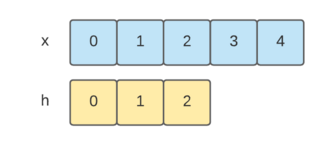

```
y[0] = h[0]*x[1]+h[1]*x[0]           = 0
y[1] = h[0]*x[2]+h[1]*x[1]*h[2]*x[0] = 1
y[2] = h[0]*x[3]+h[1]*x[2]*h[2]*x[1] = 4
y[3] = h[0]*x[4]+h[1]*x[3]+h[2]*x[2] = 7
y[4] = h[1]*x[4]+h[2]*x[3]           = 10
```





For the above example, the `convolve_gpu`:
- reads `x[0]` and `x[4]`  from the global memory twice,
- reads `x[1]`, `x[2]` and `x[3]` three times.

In general, we will get into the situtation where multiple threads read the same data from the global memory many times:




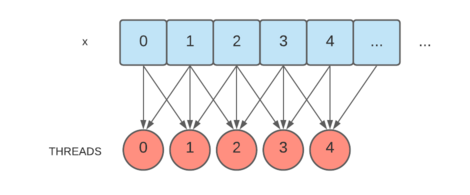

Is there any possibility to implement a GPU kernel that reads the above data from global memory only once?

## 2.2. Shared memory

The answer to the previous question is yes: using shared memory.

According to the [CUDA Toolkit documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html):
> (..) **shared memory** is expected to be a low-latency memory near each processor core (much like an L1 cache) (...)

>  **Shared memory** is expected to be much faster than global memory (...). It can be used as scratchpad memory (or software managed cache) to minimize global memory accesses from a CUDA block.

Shared memory has the following properties:
- the access time to the shared memory is much shorter than the access time to the global memory,
- it is usually much smaller than the global memory (the size of shared memory is usually counted in kilobytes, global memory -- in gigabytes),
- it's accessible only by CUDA kernel (i.e. it's not possible to write to / read from it directly from the host PC),
- its content is local for each thread block, i.e. for each block of threads, there is a separate area of shared memory.


You can check the amount of shared memory available for each thread block on your GPU by looking into device properties:

In [17]:
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Shared memory per thread block: {device_props['sharedMemPerBlock']} [bytes]")

Device name: b'GeForce GTX TITAN X'
Shared memory per thread block: 49152 [bytes]


### 2.2.1. Tiling

A typical CUDA shared memory usage pattern is as follows:


- for each thread $i$ in a block:

  1. read data from the global to shared memory,
  2. wait until all threads in the block finish 1.,
  3. perform calculations using data available in the shared memory.


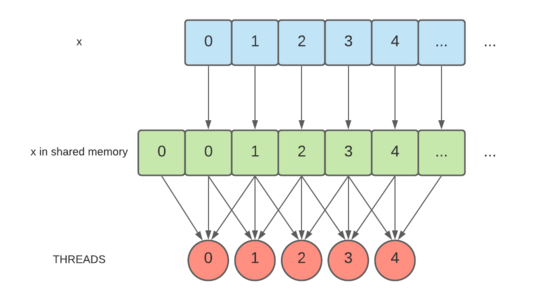

We can apply the above pattern to the `convolve_gpu_kernel` implementation:

- let's declare that each block has shared memory for $B+N-1$ samples,
  - where: $B$ is the size of the threads block, $N$ is the length of the filter, 
- for each thread $i$ in a block:

  1. read a portion of data from global to shared memory,
    - start with $k = i+o-(N-1)$,

    - read from global to shared memory: $x[k]$, $x[k+B]$, ..., and so on, until you hit the end of the shared memory area,
    - if $k + jB < 0$ or $k+jB \ge m$ for any $j$, write 0 to shared memory at position $i+jB$, otherwise write $x[k+jB]$,
  2. wait until all threads in the block finish 1.,
  3. compute $y[i]$.

Let's try the above strategy with our toy convolution example. Assume that $B = 5$.

```
x = [0, 1, 2, 3, 4]
h = [0, 1, 2]
shared_memory = [0, 0, 0, 0, 0, 0, 0]
```
(note: an unintialized shared memory may contain any arbitrary values, we used zeros just for clarity).


Some remarks: 

- We have a one block, that computes all the output samples.
- $N = 3$
- $o = 1$



**Step 1. Read a portion of data from global memory to shared memory.**

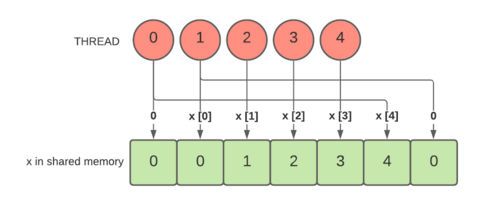



Thread $i=0$:
```
0. start with k = 0 + 1 - (3-1) = -1
1. k     =-1; i     = 0  => shared_memory[0] <- 0
2. k + B = 4; i + B = 5  => shared_memory[5] <- x[4]
3.            i + B = 10 => STOP
```

Thread $i=1$:
```
0. start with k = 0
1. k     = 0; i     = 1  => shared_memory[1] <- x[0],
2. k + B = 5; i + B = 6  => shared_memory[6] <- 0, 
3.            i + B = 11 => STOP, 
```

Thread $i=2$:
```
0. start with k = 1
1. k     = 1; i     = 2 => shared_memory[2] <- x[1],
2.            i + B = 7 => STOP, 
```


Thread $i=3$:
```
0. start with k = 2
1. k     = 2; i     = 3 => shared_memory[3] <- x[2],
2. k + B = 7; i + B = 8 => STOP, 
```

Thread $i=4$:
```
0. start with k = 3
1. k     = 3; i     = 4 => shared_memory[4] <- x[3],
2. k + B = 8; i + B = 9 => STOP, 
```

**Step 2. Wait until threads finish the above procedure**.

At this point:

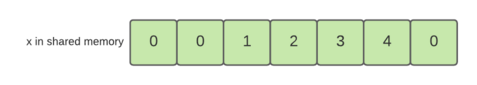

**Step 3. Compute $y$** 


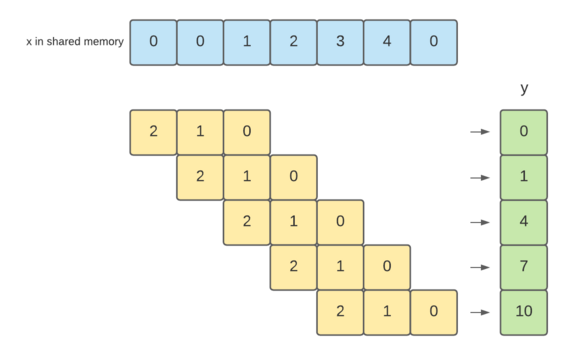

Each `x[i]` was read exactly once.

### 2.2.2. CUDA C and CuPy syntax for tiling

CUDA provides the following syntax for the shared memory area access:
- to use shared memory in CUDA C/C++ kernel, declare an `extern` variable with keyword `__shared__`,
- you can write to/read data from the shared memory area within GPU kernel code just like any other pointer in C language,
- to *wait until all threads in the block finish their job* use `__syncthreads()` function in CUDA C kernel.

When declare in the CUDA C kernel that you will use shared memory area, please remember to pass the shared memory size, which you will need for your calculations, as a kernel invocation parameter `shared_mem`:

```
kernel_object(grid, block, args, shared_mem)
```

(see also shared memory documentation available [here](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#shared-memory))

Let's implement the 1D convolution algorithm with shared memory.

**Exercise**

1. Open `2_2_convolve1d_shared_memory.cc` file.
2. Fill in the missing lines of code, marked with the `// TODO` comment.

In [21]:
%%writefile 2_2_convolve_shared_memory.py
import math
import numpy as np
import cupy as cp
import gpu_short_course.tests

convolve_gpu_kernel_src = open("2_2_convolve1d_shared_memory.cc").read()
convolve_gpu_kernel = cp.RawKernel(code=convolve_gpu_kernel_src, name="convolve1d")

def convolve_gpu(x, h):
    # Prepare input arguments.
    y = cp.empty(shape=x.shape, dtype=np.float32) 
    x = cp.asarray(x.astype(np.float32))
    h = cp.asarray(h.astype(np.float32))
    m = len(x)
    n = len(h)
    o = int(math.ceil(n/2)-1)

    # 1. DEFINE HIERARCHY OF THREADS. 
    block_size = 256
    grid_size = int(math.ceil(m/block_size))
    block = (block_size, )
    grid = (grid_size, )

    # 2. DETERMINE HOW MUCH SHARED MEMORY WE NEED
    shared_mem_size = block_size+n-1                          # Number of elements in shared memory.
    shared_mem_size_bytes = shared_mem_size*y.dtype.itemsize  # Number of bytes.
    
    # Make sure we are not exceeding the available shared memory size:
    device_props = cp.cuda.runtime.getDeviceProperties(0)
    if shared_mem_size_bytes > device_props['sharedMemPerBlock']:    
        raise ValueError("Declared shared memory size exceeds the amount available for the device.")

    # 3. INVOKE THE KERNEL.
    convolve_gpu_kernel(grid, block, args=(y, x, h, m, n, o, shared_mem_size), shared_mem=shared_mem_size_bytes)
    return y.get()

gpu_short_course.tests.run_convolve(convolve_gpu)

Overwriting 2_2_convolve_shared_memory.py


Let's test the implementation first:


In [22]:
! python 2_2_convolve_shared_memory.py --mode test

GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
All tests passed.


In [23]:
! nvprof --trace gpu python 2_2_convolve_shared_memory.py --mode benchmark n=10

==23303== NVPROF is profiling process 23303, command: python 2_2_convolve_shared_memory.py --mode benchmark n=10
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0558 seconds (+/- 0.1445), median: 0.0076
==23303== Profiling application: python 2_2_convolve_shared_memory.py --mode benchmark n=10
==23303== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   88.23%  56.168ms        10  5.6168ms  5.6022ms  5.6401ms  convolve1d
                    6.37%  4.0551ms        10  405.51us  355.72us  423.34us  [CUDA memcpy DtoH]
                    5.40%  3.4403ms        20  172.01us  1.7280us  347.21us  [CUDA memcpy HtoD]
No API activities were profiled.


Compare the above result with that of a convolution from section 2.1.2.

##  2.3. Constant memory

In our GPU convolution implementation, there is still one more array located in the global memory area whose values are read over and over again -- the filter $h$ cofficients.

The filter coefficients, like the input samples, could be pre-read by each thread block to shared memory, similar to what we did with the input signal $x$ -- we leave the implementation of this to the student as homework. 

In this exercise, we will use another type of memory to store the filter coefficients: i.e., constant memory.

According to the [CUDA Toolkit documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html):

> (...) The constant memory space resides in device memory and is cached in the constant cache. (...)

> Constants are immutable and may not be modified from the device, even between parent and child launches. That is to say, the value of all __constant__ variables must be set from the host prior to launch. Constant memory is inherited automatically by all child kernels from their respective parents.

> An SM has:
a read-only constant cache that is shared by all functional units and speeds up reads from the constant memory space, which resides in device memory (...)

Constant memory has the following properties:
- it resides in global memory, and is accessed by a Multiprocessor via *constant cache*, therefore reading from constant memory usually costs the time required to access low-latency cache memory, and usually is much faster than accessing global memory,
-  is read-only,
- due to the limited size of constant cache, the available *constant memory* space is much smaller than the available global memory,
- it can be accesed by a CUDA kernel,
- it can be initialized by host code.


Let's check the amout of constant memory available on our GPU:

In [21]:
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Constant memory size: {device_props['totalConstMem']} [bytes]")

Device name: b'GeForce GTX TITAN X'
Constant memory size: 65536 [bytes]


### 2.3.1. CUDA C and CuPy syntax for constant memory

To use constant memory in CuPy:
- in CUDA source code declare a global variable (e.g. an array) with `__constant__` keyword - this will be our pointer to constant memory,
- you can use the constant memory pointer in CUDA code as any other variable,
- create `cupy.RawModule` class to build kernels in CuPy (do not use `cupy.RawKernel`),
- to get a handle to kernel function: use method `.get_function` on the created `RawModule`, 
- to get a handle to CUDA constant symbol: use method `.get_global` on the created `RawModule`,
- wrap the handle to constant symbol into a cupy array, pass the handle to memptr argument of `cupy.ndarray` type,
- fill the const ndarray with data.

**Exercise**

1. Open `2_3_convolve1d_shared_const_memory.cc` file.
2. Update lines of code marked with the `// TODO` comment.

In [24]:
%%writefile 2_3_convolve_const_memory.py
import math
import sys
import numpy as np
import cupy as cp
import gpu_short_course.tests

convolve_gpu_kernel_src = open("2_3_convolve1d_shared_const_memory.cc").read()

convolve_gpu_module = cp.RawModule(code=convolve_gpu_kernel_src)
device_props = cp.cuda.runtime.getDeviceProperties(0)

# Get a handle to the `convolve1d` function.
convolve_gpu_kernel = convolve_gpu_module.get_function("convolve1d")

# Get a handle to the constant variable `h`.
# First, determine the size of the filter we want to use.
# For testing purpose, we will use a filter with 5 coefficients.
# For benchmarking, we will use a filter with 256 coefficients.
mode = sys.argv[2]
if mode == "test":
    filter_size = 5
elif mode == "benchmark":
    filter_size = 256

if filter_size*4 > device_props["totalConstMem"]:
    # times 4, because we using 32-bit float type.
    raise ValueError("We are exceeding available constant memory size!")

# Make sure we are not exceeding available const memory area.
# Get a C pointer to the constant variable h.
h_ptr = convolve_gpu_module.get_global("h")
# Create the `h` array.
h = cp.ndarray(shape=(filter_size,), dtype=cp.float32, memptr=h_ptr)
h_host = np.random.rand(filter_size).astype(np.float32)
# Copy filter coefficients from host to GPU.
h.set(h_host)

def convolve_gpu(x):
    # Prepare input arguments.
    y = cp.empty(shape=x.shape, dtype=np.float32) 
    x = cp.asarray(x.astype(np.float32))
    m = len(x)
    n = len(h)
    o = int(math.ceil(n/2)-1)

    # 1. DEFINE HIERARCHY OF THREADS. 
    block_size = 256
    grid_size = int(math.ceil(m/block_size))
    block = (block_size, )
    grid = (grid_size, )

    # 2. DETERMINE HOW MUCH SHARED MEMORY WE NEED
    shared_mem_size = block_size+n-1                          # Number of elements in shared memory.
    shared_mem_size_bytes = shared_mem_size*y.dtype.itemsize  # Number of bytes.
    # Make sure we are not exceeding the available shared memory size:
    if shared_mem_size_bytes > device_props['sharedMemPerBlock']:    
        raise ValueError("We are exceeding available shared memory size!")
    # 3. INVOKE THE KERNEL.
    convolve_gpu_kernel(grid, block, args=(y, x, m, n, o, shared_mem_size), shared_mem=shared_mem_size_bytes)
    return y.get()

gpu_short_course.tests.run_convolve_const(convolve_gpu, h=h_host)

Writing 2_3_convolve_const_memory.py


In [25]:
! python 2_3_convolve_const_memory.py --mode test

GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
All tests passed.


In [26]:
! nvprof --trace gpu python 2_3_convolve_const_memory.py --mode benchmark

==23443== NVPROF is profiling process 23443, command: python 2_3_convolve_const_memory.py --mode benchmark
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmark result: 
Average processing time: 0.0027 seconds (+/- 0.0001), median: 0.0027
==23443== Profiling application: python 2_3_convolve_const_memory.py --mode benchmark
==23443== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   49.87%  75.555ms       100  755.55us  752.95us  759.44us  convolve1d
                   27.68%  41.943ms       100  419.43us  409.96us  445.13us  [CUDA memcpy DtoH]
                   22.45%  34.011ms       101  336.74us  1.3760us  346.89us  [CUDA memcpy HtoD]
No API activities were profiled.


## 2.4. Texture memory

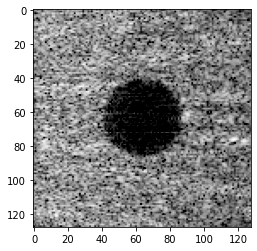

In [16]:
import matplotlib.pyplot as plt
import scipy.signal
import gpu_short_course.datasets
import math
import cupy as cp
import numpy as np

rf, context = gpu_short_course.datasets.read_example_data("pwi_cyst_simulated.pkl")
n_transmits, n_elements, n_samples = rf.shape

# distance between the leftmost and rightmost element of probe (centers)
probe_width = (n_elements-1) * context["pitch"]

nx, nz = 128, 128
grid_x = np.linspace(-15, 15, nx)*1e-3
grid_z = np.linspace( 20, 50, nz)*1e-3

# Position of each probe element (OX).
elements_x = np.linspace(-probe_width/2, probe_width/2, n_elements)

beamform_src = open("2_4_beamform.cc").read()
beamform_kernel = cp.RawKernel(code=beamform_src, name="beamform")

block = (32, 32)
grid = (int(math.ceil(nz/block[0])), int(math.ceil(nx/block[1])))

rf_gpu = cp.asarray(rf, dtype=cp.float32)
grid_x_gpu = cp.asarray(grid_x, dtype=cp.float32)
grid_z_gpu = cp.asarray(grid_z, dtype=cp.float32)
elements_x_gpu = cp.asarray(elements_x, dtype=cp.float32)
angles_gpu = cp.asarray(context["angles"], dtype=cp.float32)

speed_of_sound = cp.float32(context["speed_of_sound"])
sampling_frequency = cp.float32(context["sampling_frequency"])

output_gpu = cp.empty(shape=(nx, nz), dtype=cp.float32)

beamform_kernel(
    grid, block, 
    args=(
        output_gpu, rf_gpu,
        grid_z_gpu, nz,
        grid_x_gpu, nx,
        angles_gpu, n_transmits,
        elements_x_gpu, n_elements,
        n_samples, 
        speed_of_sound, sampling_frequency
    )
)
output = output_gpu.get()

envelope = np.abs(scipy.signal.hilbert(output))
bmode = 20*np.log10(envelope/np.max(envelope))
plt.imshow(bmode, cmap="gray", vmin=-30, vmax=0)

In [14]:
%%writefile 2_4_beamform.py

import scipy.signal
import gpu_short_course.datasets
import gpu_short_course.ultrasound_imaging
import math
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

rf, context = gpu_short_course.datasets.read_example_data("pwi_cyst_simulated.pkl")
n_transmits, n_elements, n_samples = rf.shape

# distance between the leftmost and rightmost element of probe (centers)
probe_width = (n_elements-1) * context["pitch"]

grid_x = gpu_short_course.ultrasound_imaging.DEFAULT_X_GRID
grid_z = gpu_short_course.ultrasound_imaging.DEFAULT_Z_GRID
nx, nz = len(grid_x), len(grid_z)

# Position of each probe element (OX).
elements_x = np.linspace(-probe_width/2, probe_width/2, n_elements)

beamform_src = open("2_4_beamform.cc").read()
beamform_kernel = cp.RawKernel(code=beamform_src, name="beamform")

block = (16, 16)
grid = (int(math.ceil(nz/block[0])), int(math.ceil(nx/block[1])))

rf_gpu = cp.asarray(rf, dtype=cp.float32)
grid_x_gpu = cp.asarray(grid_x, dtype=cp.float32)
grid_z_gpu = cp.asarray(grid_z, dtype=cp.float32)
elements_x_gpu = cp.asarray(elements_x, dtype=cp.float32)
angles_gpu = cp.asarray(context["angles"], dtype=cp.float32)
speed_of_sound = cp.float32(context["speed_of_sound"])
sampling_frequency = cp.float32(context["sampling_frequency"])
output_gpu = cp.empty(shape=(nx, nz), dtype=cp.float32)

for i in range(10):
    rf_host = rf+np.random.randn(*rf.shape)*1e-11
    rf_gpu = cp.asarray(rf_host, dtype=cp.float32)
    beamform_kernel(
        grid, block, 
        args=(
            output_gpu, rf_gpu,
            grid_z_gpu, nz,
            grid_x_gpu, nx,
            angles_gpu, n_transmits,
            elements_x_gpu, n_elements,
            n_samples, 
            speed_of_sound, sampling_frequency
        )
    )
    output = output_gpu.get()
    plt.imshow(output)
    plt.savefig("2_4_beamform_output.png")

Overwriting 2_4_beamform.py


In [5]:
! nvprof --trace gpu python 2_4_beamform.py

==30338== NVPROF is profiling process 30338, command: python 2_4_beamform.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
==30338== Profiling application: python 2_4_beamform.py
==30338== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   71.29%  18.535ms        15  1.2357ms     992ns  1.6878ms  [CUDA memcpy HtoD]
                   28.44%  7.3933ms        10  739.33us  735.67us  747.38us  beamform
                    0.27%  69.409us        10  6.9400us  6.7840us  7.1370us  [CUDA memcpy DtoH]
No API activities were profiled.


#### Using constant memory in beamformer

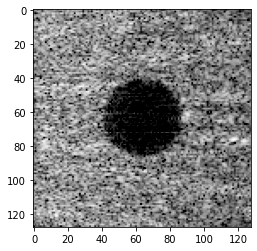

In [2]:
import scipy.signal
import gpu_short_course.datasets
import gpu_short_course.ultrasound_imaging
import math
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

rf, context = gpu_short_course.datasets.read_example_data("pwi_cyst_simulated.pkl")
n_transmits, n_elements, n_samples = rf.shape

grid_x = gpu_short_course.ultrasound_imaging.DEFAULT_X_GRID
grid_z = gpu_short_course.ultrasound_imaging.DEFAULT_Z_GRID
nx, nz = len(grid_x), len(grid_z)
elements_x = gpu_short_course.datasets.get_elements_x(context, n_elements).astype(np.float32)
angles = context["angles"].astype(np.float32)

beamform_src = open("2_4_beamform_const_params.cc").read()
beamform_module = cp.RawModule(code=beamform_src)

beamform_kernel = beamform_module.get_function("beamform_const_params")
angles_ptr = beamform_module.get_global("angles")
elements_x_ptr = beamform_module.get_global("elements_x")

block = (32, 32)
grid = (int(math.ceil(nz/block[0])), int(math.ceil(nx/block[1])))

rf_gpu     = cp.asarray(rf, dtype=cp.float32)
grid_x_gpu = cp.asarray(grid_x, dtype=cp.float32)
grid_z_gpu = cp.asarray(grid_z, dtype=cp.float32)
# Here we set constant arrays.
elements_x_gpu = cp.ndarray(shape=elements_x.shape, dtype=cp.float32, memptr=elements_x_ptr)
elements_x_gpu.set(elements_x)
angles_gpu = cp.ndarray(shape=angles.shape, dtype=cp.float32, memptr=angles_ptr)
angles_gpu.set(angles)
# Make sure scalar values are of proper type.
speed_of_sound = cp.float32(context["speed_of_sound"])
sampling_frequency = cp.float32(context["sampling_frequency"])

output_gpu = cp.empty(shape=(nx, nz), dtype=cp.float32)

beamform_kernel(
    grid, block, 
    args=(
        output_gpu, rf_gpu,
        grid_z_gpu, nz,
        grid_x_gpu, nx,
        n_transmits, n_elements, n_samples, 
        speed_of_sound, sampling_frequency
    )
)
output = output_gpu.get()

envelope = np.abs(scipy.signal.hilbert(output))
bmode = 20*np.log10(envelope/np.max(envelope))
plt.imshow(bmode, cmap="gray", vmin=-30, vmax=0)

In [8]:
%%writefile 2_4_beamform_const_params.py

import scipy.signal
import gpu_short_course.datasets
import gpu_short_course.ultrasound_imaging
import math
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

rf, context = gpu_short_course.datasets.read_example_data("pwi_cyst_simulated.pkl")
n_transmits, n_elements, n_samples = rf.shape

grid_x = gpu_short_course.ultrasound_imaging.DEFAULT_X_GRID
grid_z = gpu_short_course.ultrasound_imaging.DEFAULT_Z_GRID
nx, nz = len(grid_x), len(grid_z)
elements_x = gpu_short_course.datasets.get_elements_x(context, n_elements).astype(np.float32)
angles = context["angles"].astype(np.float32)

beamform_src = open("2_4_beamform_const_params.cc").read()
beamform_module = cp.RawModule(code=beamform_src)

beamform_kernel = beamform_module.get_function("beamform_const_params")
angles_ptr = beamform_module.get_global("angles")
elements_x_ptr = beamform_module.get_global("elements_x")

block = (32, 32)
grid = (int(math.ceil(nz/block[0])), int(math.ceil(nx/block[1])))

rf_gpu     = cp.asarray(rf, dtype=cp.float32)
grid_x_gpu = cp.asarray(grid_x, dtype=cp.float32)
grid_z_gpu = cp.asarray(grid_z, dtype=cp.float32)
# Here we set constant arrays.
elements_x_gpu = cp.ndarray(shape=elements_x.shape, dtype=cp.float32, memptr=elements_x_ptr)
elements_x_gpu.set(elements_x)
angles_gpu = cp.ndarray(shape=angles.shape, dtype=cp.float32, memptr=angles_ptr)
angles_gpu.set(angles)
# Make sure scalar values are of proper type.
speed_of_sound = cp.float32(context["speed_of_sound"])
sampling_frequency = cp.float32(context["sampling_frequency"])

output_gpu = cp.empty(shape=(nx, nz), dtype=cp.float32)

for i in range(10):
    rf_host = rf+np.random.randn(*rf.shape)*1e-11
    rf_gpu = cp.asarray(rf_host, dtype=cp.float32)

    beamform_kernel(
        grid, block, 
        args=(
            output_gpu, rf_gpu,
            grid_z_gpu, nz,
            grid_x_gpu, nx,
            n_transmits, n_elements, n_samples, 
            speed_of_sound, sampling_frequency
    )
)
output = output_gpu.get()
plt.imshow(output)
plt.savefig("2_4_beamform_const_params_output.png")

Overwriting 2_4_beamform_const_params.py


In [9]:
! nvprof --trace gpu python 2_4_beamform_const_params.py

==30429== NVPROF is profiling process 30429, command: python 2_4_beamform_const_params.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
==30429== Profiling application: python 2_4_beamform_const_params.py
==30429== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   74.09%  18.532ms        15  1.2355ms  1.0240us  1.6888ms  [CUDA memcpy HtoD]
                   25.89%  6.4756ms        10  647.56us  643.54us  650.16us  beamform_const_params
                    0.03%  6.8160us         1  6.8160us  6.8160us  6.8160us  [CUDA memcpy DtoH]
No API activities were profiled.


## 2.5. Texture memory

# References

- [CUDA Toolkit Documentation: Memory Hierarchy](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#memory-hierarchy)
- [CUDA Best Practices Guide: Shared Memory](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory)
- [CUDA Best Practices Guide: Constant Memory](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#constant-memory)